# Bacterial Species Classification
The rapid and accurate classification of microorganisms is a problem that is of vital importance in the fields of biology and medicine. Medical diagnosis of infections inherently hinges on the identification of bacteria, fungus, or plant microorganism samples taken from a patient. Additionally, microbiologists are constantly tasked with identifying and counting the microorganisms contained in a sample. The [microbes dataset](https://www.kaggle.com/datasets/sayansh001/microbes-dataset) provides a dataset covering 10 different bacterial genera along with a number of (potential) characteristic structual features. Microbe classification is a difficult problem due to the similarity between many microbe species, wide ranges of shapes within species, and the undefined orientation of the organism (i.e., how do we account for the physical rotation of the bacterium?). We are given 24 features which are engineered from the pictures which may prove to be useful in bacterial identification. Here are some examples to get an idea:
- **EulerNumber** $\leftarrow$ The number of objects in the region minus the number of holes in those objects.
- **Orientation** $\leftarrow$ The overall direction of the shape. The value ranges from -90 degrees to 90 degrees.
- **Solidity** $\leftarrow$ The ratio of area of an object to the area of a convex hull of the object. Computed as Area/ConvexArea.
- **EquivDiameter** $\leftarrow$ The diameter of a circle with the same area as the region.

#### Data Source
The data can be found in 2 separate places: Kaggle and Mendeley Data. I'll provide direct links to both here:
- https://www.kaggle.com/datasets/sayansh001/microbes-dataset?datasetId=2078183
- https://data.mendeley.com/datasets/f9m85ptmvc/3

## The Bacteria in Question
We are given 10 different bacteria to predict. I will list each one here and provide an example picture, so we can get a better idea of what we are dealing with. Notice the distinct shape of each one and some similarities between bacterial types. Microscopes use light to provide us a representation of an organism and given how light is used, the same organism could be represented in a drastically different way!
             
|   |   |   |
|---|---|---|
|<figure><img src="Images/Spirogyra.jpeg" alt="drawing" width="225"/><figcaption>Spirogyra</figcaption></figure>|<figure><img src="Images/Volvox.jpg" alt="drawing" width="225"/><figcaption>Volvox</figcaption></figure>|<figure><img src="Images/Pithophora.jpg" alt="drawing" width="225"/><figcaption>Pithophora</figcaption></figure>
   |
|<figure><img src="Images/Yeast.jpg" alt="drawing" width="225"/><figcaption>Yeast</figcaption></figure>|<figure><img src="Images/Raizopus.webp" alt="drawing" width="225"/><figcaption>Raizopus</figcaption></figure>|<figure><img src="Images/Penicillum.jpg" alt="drawing" width="225"/><figcaption>Penicillum</figcaption></figure>
   |
|<figure><img src="Images/Aspergillus sp.png" alt="drawing" width="225"/><figcaption>Aspergillus</figcaption></figure>   |<figure><img src="Images/Protozoa.jpg" alt="drawing" width="225"/><figcaption>Protozoa</figcaption></figure>   |<figure><img src="Images/Diatom.png" alt="drawing" width="225"/><figcaption>Diatom</figcaption></figure>   |
|   |<figure><img src="Images/Ulothrix.jpg" alt="drawing" width="225"/><figcaption>Ulothrix</figcaption></figure>   |   |

## Exploratory Data Analysis
We will explore and analyze the dataset in a number of steps:
1. Data Preparation and Summarization
2. Dimensionality Reduction
3. Model Training
4. Model Testing
5. Hyperparameter Tuning
6. Results
7. Conclusion

### Data Preparation and Summarization


In [511]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [512]:
# Load the data in as a dataframe and describe each feature
df = pd.read_csv("Data/microbes.csv")
df.describe()

# It seems that the first feature is simply an index and will not help in our analysis; drop it\
df.drop(labels=df.columns[0], axis=1, inplace=True)

# Examine our data types so we can prepare them for the model
print(df.dtypes)
print(df["microorganisms"])

# We'll want to encode the various levels of of "microorganisms" feature into integers, so we can feed them into the model
organisms = df["microorganisms"].unique().tolist()

# Make mappings to and from each organisms
organism_to_int = {organism: i for i, organism in enumerate(organisms)}
int_to_organism = {val: key for key, val in organism_to_int.items()}

# Apply the encoding
df["microorganisms"] = [organism_to_int[organism] for organism in df["microorganisms"].tolist()]

df.head()

,Unnamed: 0,Solidity,Eccentricity,EquivDiameter,Extrema,FilledArea,Extent,Orientation,EulerNumber,BoundingBox1,...,ConvexHull3,ConvexHull4,MajorAxisLength,MinorAxisLength,Perimeter,ConvexArea,Centroid1,Centroid2,Area,raddi
count,30527.00000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,...,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.000000,30527.00000,30527.000000
mean,15263.00000,9.677744,19.466921,3.633348,11.871832,0.420022,5.840625,11.751004,22.380901,10.919027,...,11.046482,11.021988,1.605159,1.014179,0.829416,0.254596,11.752783,11.554286,0.80278,5.214598
std,8812.53017,4.063437,3.479828,2.210851,6.045135,0.875091,3.250999,6.575319,0.962906,6.093280,...,6.089508,6.089467,1.662537,1.224326,1.152165,0.971035,6.029756,5.700637,1.17043,2.805199
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,7631.50000,6.570000,17.300000,2.180000,6.790000,0.093700,3.280000,6.005000,22.300000,5.690000,...,5.790000,5.755000,0.635000,0.421000,0.253000,0.034700,6.570000,7.110000,0.21800,3.080000
50%,15263.00000,9.350000,20.700000,3.380000,12.000000,0.229000,5.260000,12.100000,22.600000,10.900000,...,11.000000,11.000000,1.160000,0.745000,0.518000,0.085700,12.100000,11.200000,0.51400,5.320000
75%,22894.50000,12.600000,22.200000,4.580000,17.200000,0.434500,7.850000,17.200000,22.900000,15.800000,...,15.900000,15.900000,2.070000,1.220000,0.968000,0.200000,16.900000,16.200000,0.93400,7.050000
max,30526.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000


Solidity           float64
Eccentricity       float64
EquivDiameter      float64
Extrema            float64
FilledArea         float64
Extent             float64
Orientation        float64
EulerNumber        float64
BoundingBox1       float64
BoundingBox2       float64
BoundingBox3       float64
BoundingBox4       float64
ConvexHull1        float64
ConvexHull2        float64
ConvexHull3        float64
ConvexHull4        float64
MajorAxisLength    float64
MinorAxisLength    float64
Perimeter          float64
ConvexArea         float64
Centroid1          float64
Centroid2          float64
Area               float64
raddi              float64
microorganisms      object
dtype: object
0        Spirogyra
1        Spirogyra
2        Spirogyra
3        Spirogyra
4        Spirogyra
           ...    
30522     Ulothrix
30523     Ulothrix
30524     Ulothrix
30525     Ulothrix
30526     Ulothrix
Name: microorganisms, Length: 30527, dtype: object


,Solidity,Eccentricity,EquivDiameter,Extrema,FilledArea,Extent,Orientation,EulerNumber,BoundingBox1,BoundingBox2,...,ConvexHull4,MajorAxisLength,MinorAxisLength,Perimeter,ConvexArea,Centroid1,Centroid2,Area,raddi,microorganisms
0,10.70,15.8,5.43,3.75,0.785,8.14,2.15,22.3,2.97,10.90,...,2.97,1.34,1.61,0.683,0.195,3.63,12.10,1.310,7.99,0
1,5.60,18.3,4.14,6.16,0.364,3.51,18.60,22.5,5.41,19.20,...,5.47,1.52,1.52,1.010,0.215,6.01,20.60,0.765,7.99,0
2,8.32,19.8,4.63,6.66,0.415,5.85,21.00,22.4,5.96,10.20,...,5.96,1.63,1.38,1.110,0.182,6.55,11.50,0.953,7.99,0
3,10.10,17.9,7.29,11.10,1.470,6.30,9.94,21.9,8.81,10.70,...,8.88,2.04,2.12,0.715,0.371,10.30,12.00,2.340,7.99,0
4,6.27,20.2,20.10,10.70,14.700,3.97,2.58,11.9,10.20,1.22,...,10.20,7.78,6.21,6.800,4.440,14.00,9.55,17.600,7.99,0


In [513]:
class Data():
    def __init__(self, df, target_col: str, train_proportion: float=0.75, scale: bool=True):
        """
        Class for storing prepared data for the machine-learning pipeline.
        Automatically splits the data into training and testing sets according
        to the train_proportion.
        
        Parameters
        ----------
        df: Pandas DataFrame
            The prepared data in the form of a Pandas dataframe. This should
            contain both the features and the target.
        
        target_col: string
            The name of the taget column in the dataframe; i.e., the feature
            we are trying to classify.
        
        train_proportion: float, default=0.75
            What proportion of the dataset we should dedicate as training
            data. A complementary amount will be used to test the dataset.
        
        scale: bool, default=True
            Whether to scale to each feature in the range [0, 1]
        """
        # Extract the labels (y) and the features (x), the feature names and the target names
        self.y = df[target_col].to_numpy()
        x_tmp = df.drop(labels=target_col, axis=1)
        
        self.target = target_col
        self.features_orig = x_tmp.columns.to_list()
        self.features = x_tmp.columns.to_list()
        
        self.x = x_tmp.to_numpy()
        if scale:
            self.x = MinMaxScaler().fit_transform(self.x)
        
        # Split our data into training and testing sets
        (self.x_train, self.x_test,
         self.y_train, self.y_test) = train_test_split(self.x, self.y, train_size=train_proportion)
        
        self.train_proportion = train_proportion
        self.test_proportion = 1 - train_proportion
    
    def __repr__(self):
        return f"""
Data Description:
├── Target Variable:  {self.target}
├── Feature Size:     {len(self.features)}
└── Observation Size: {len(self.y)}
Train/Test Data Description:
├── Train Proportion:    {self.train_proportion}
├── Test Proportion:     {self.test_proportion}
├── Train Size:          {len(self.y_train)}
├── Test Size:           {len(self.y_test)}
├── Train Features Size: {self.x_train.shape[1]}
└── Test Features Size:  {self.x_test.shape[1]}
"""
    
    def prune_features(self, mask:list[bool]):
        """
        Remove features from the training and testing sets. The full data
        (x, y) will remain unchanged in case one wishes to re-split the data.
        
        Arguments
        ---------
        mask: list of bools
            A mask the size of the features dictating whether we should keep a
            feature or remove it.
        """
        self.features = [feature for (feature, keep) in zip(self.features, mask) if keep]
        self.x_train = self.x_train[:, mask]
        self.x_test = self.x_test[:, mask]
        

In [514]:
data = Data(df, target_col="microorganisms", train_proportion=0.75)
print(data)
print(data.features)
print(data.x_train)


Data Description:
├── Target Variable:  microorganisms
├── Feature Size:     24
└── Observation Size: 30527
Train/Test Data Description:
├── Train Proportion:    0.75
├── Test Proportion:     0.25
├── Train Size:          22895
├── Test Size:           7632
├── Train Features Size: 24
└── Test Features Size:  24

['Solidity', 'Eccentricity', 'EquivDiameter', 'Extrema', 'FilledArea', 'Extent', 'Orientation', 'EulerNumber', 'BoundingBox1', 'BoundingBox2', 'BoundingBox3', 'BoundingBox4', 'ConvexHull1', 'ConvexHull2', 'ConvexHull3', 'ConvexHull4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'ConvexArea', 'Centroid1', 'Centroid2', 'Area', 'raddi']
[[5.13043478e-01 8.13043478e-01 1.93043478e-01 ... 9.13043478e-01
  3.81304348e-02 2.83478261e-01]
 [5.21739130e-01 9.00000000e-01 7.69565217e-02 ... 7.91304348e-01
  6.34782609e-03 5.56521739e-02]
 [6.08695652e-01 7.00000000e-01 1.58695652e-02 ... 4.69565217e-01
  3.40869565e-04 1.44782609e-01]
 ...
 [3.28695652e-01 9.47826087e-01 9.69565

### Dimensionality Reduction
With 30527 observations, we have a decent amount of data to work with, but we are also working in a high-dimensional space with 24 features. Performing dimensionality reduction may help us prevent from overfitting the model, and a less sparse space will help in classification. Unfortunately, PCA may not be appropriate since one of our features `Orientation` is a circular random variable. Additonally, it is possible that non-linear relationships may exist between the organisms. In this approach, we will attempt to first use a *random forest* to extract the most important features from our *training data* before we begin training the model itself.

In [515]:
def random_forest_reduction(data, n_estimators: int=100, n_jobs: int=-1, verbosity: int=0):
    """
    Uses a Random Forest model to helm select the most informative features
    from a dataset.
    
    Arguments
    ---------
    data: A Data() object
        The prepared data whose training set will be fed into the model.
    
    n_estimators: integer, default=100
        How many trees to use in the random forest ensemble
    
    n_jobs: integer, default=-1
        The number of jobs that can be run in parallel. -1 uses all cores.
    
    verbosity: integer, default=0
        Whether to output status messages when fitting and predicting the
        model.
        
    Returns
    -------
    selection_mask: np.ndarray of bools
        An array corresponding to whether a dimension ought to be kept or
        thrown away.
    forest: RandomForestClassifier() object
        The fitted random forest model
    """
    # Instantiate and fit the random forest to the training data
    forest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs, verbose=verbosity)
    forest.fit(data.x_train, data.y_train)
    
    # Create our selector to extract the most informative dimensions
    selector =  SelectFromModel(forest, prefit=True)
    
    # Extract the selection mask to see what features we ought to keep or toss
    selection_mask = selector.get_support()
    
    return selection_mask, forest

In [516]:
# Grab our selection mask and forest model from the random forest reduction
mask, _ = random_forest_reduction(data, n_estimators=50, n_jobs=-1, verbosity=1)

# Update our data to reflect the dimensionality reduction
data.prune_features(mask)
print(data)
print(data.features_orig)
print(data.features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.



Data Description:
├── Target Variable:  microorganisms
├── Feature Size:     12
└── Observation Size: 30527
Train/Test Data Description:
├── Train Proportion:    0.75
├── Test Proportion:     0.25
├── Train Size:          22895
├── Test Size:           7632
├── Train Features Size: 12
└── Test Features Size:  12

['Solidity', 'Eccentricity', 'EquivDiameter', 'Extrema', 'FilledArea', 'Extent', 'Orientation', 'EulerNumber', 'BoundingBox1', 'BoundingBox2', 'BoundingBox3', 'BoundingBox4', 'ConvexHull1', 'ConvexHull2', 'ConvexHull3', 'ConvexHull4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'ConvexArea', 'Centroid1', 'Centroid2', 'Area', 'raddi']
['Solidity', 'Eccentricity', 'EquivDiameter', 'FilledArea', 'Extent', 'BoundingBox4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'ConvexArea', 'Area', 'raddi']


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


### Model Training
It appears that we removed a lot of parameters that would likely be highly correlated with one another and not bring much additional information. For example, one would expect the 4 bounding boxes to be related to each-other. The dimensionality-reduction selector likely choose `BoundingBox4` as the most informative bounding box since `BoundingBox1`, `BoundingBox2`, and `BoundingBox3` are not selected.

Now, let's train our model using a *k-nearest-neighbors* approach. We will utilize the `KNeighborsClassifier()` from *sklearn* as our supervised learning model.

For simplicity, we will examine a simple model here using our **training data**, then tune our hyperparameters and determine the performance of our final model via cross-validation with the testing data.

In [517]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1, p=2)
knn.fit(data.x_train, data.y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

In [518]:
class DataTesting():
    def __init__(self, labels_pred, labels_truth, decoder: dict=None):
        """
        Class for testing our a fitted model given truth and predicted labels.
        
        Parameters
        ----------
        labels_pred: np.ndarray
            A numpy array containing the predicted labels from the model
        labels_truth: np.ndarray
            A numpy array containing the true labels from the model
        decoder: dict, default=None
            An optional dictionary used to decode the label values. Has the
            format decoder[encoded_label] -> label_name
        """
        assert isinstance(labels_pred, np.ndarray) and isinstance(labels_truth, np.ndarray), "Labels must be a NumPy array."
        assert labels_pred.shape == labels_truth.shape, "Labels must be of equal shape."
        self.pred = labels_pred
        self.truth = labels_truth
        self.decoder = {key: val for key, val in decoder.items()}
    
    def report(self):
        """
        Returns a report on evaluation metrics for the model such as
        specicifity and sensitivity.
        
        Returns
        -------
        report_df: pd.DataFrame
            The resulting model report in the form of a pandas dataframe
        """
        report = classification_report(
            self.truth,
            self.pred,
            output_dict=True
        )
                
        # Make a dataframe and rename the columnns
        report_df = pd.DataFrame.from_dict(report)
        report_df.rename(
            columns={str(key): val for key, val in self.decoder.items()},
            inplace=True
        )
                
        return report_df
    
    def confusion_matrix(self):
        """
        Computes the confusion matrix for the model.
        
        Returns
        -------
        confusion_matrix: pd.DataFrame
            The confusion matrix
        """
        n_features = len(np.unique(self.truth))
        matrix = np.zeros((n_features, n_features))
        for pred, truth in zip(self.pred, self.truth):
            matrix[pred, truth] += 1
        
        confusion_matrix = pd.DataFrame(matrix)
        confusion_matrix.rename(columns=self.decoder, inplace=True)
        confusion_matrix.rename(index=self.decoder, inplace=True)
        
        return confusion_matrix

    def confusion_matrix_plot(self, confusion_matrix=None):
        """
        Returns a figure corresponding to the model's confusion matrix.
        
        Arguments
        ---------
        confusion_matrix: None or pd.DataFrame, default=None
            The confusion matrix to plot against. If None, it will generate
            one from the class attributes
        """
        fig, ax = plt.subplots(figsize=(11, 10), tight_layout=True)        
        sns.heatmap(
            data=confusion_matrix,
            robust=True,
            cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True),
            annot=True,
            fmt=".100g",
            linewidth=0.5,
            ax=ax,
            square=True
        )
        
        ax.set_xlabel("True Label")
        ax.set_ylabel("Predicted Label")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        return fig, ax

,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix,accuracy,macro avg,weighted avg
precision,0.957071,0.942630,0.904808,0.956443,0.997896,0.953650,0.961593,0.985497,0.951220,0.984546,0.965975,0.959535,0.966449
recall,0.804671,1.000000,0.913592,0.991048,1.000000,1.000000,0.929849,1.000000,0.998537,0.934192,0.965975,0.957189,0.965975
f1-score,0.874279,0.970468,0.909179,0.973438,0.998947,0.976275,0.945455,0.992696,0.974304,0.958708,0.965975,0.957375,0.965665
support,471.000000,3204.000000,1030.000000,2681.000000,1897.000000,823.000000,2908.000000,2922.000000,1367.000000,5592.000000,0.965975,22895.000000,22895.000000


,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix
Spirogyra,379.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,7.0
Volvox,10.0,3204.0,34.0,13.0,0.0,0.0,54.0,0.0,0.0,84.0
Pithophora,9.0,0.0,941.0,6.0,0.0,0.0,27.0,0.0,0.0,57.0
Yeast,14.0,0.0,3.0,2657.0,0.0,0.0,64.0,0.0,0.0,40.0
Raizopus,2.0,0.0,0.0,0.0,1897.0,0.0,0.0,0.0,0.0,2.0
Penicillum,1.0,0.0,2.0,0.0,0.0,823.0,11.0,0.0,0.0,26.0
Aspergillus sp,14.0,0.0,9.0,0.0,0.0,0.0,2704.0,0.0,0.0,85.0
Protozoa,1.0,0.0,5.0,1.0,0.0,0.0,3.0,2922.0,1.0,32.0
Diatom,8.0,0.0,10.0,1.0,0.0,0.0,16.0,0.0,1365.0,35.0
Ulothrix,33.0,0.0,22.0,3.0,0.0,0.0,23.0,0.0,1.0,5224.0


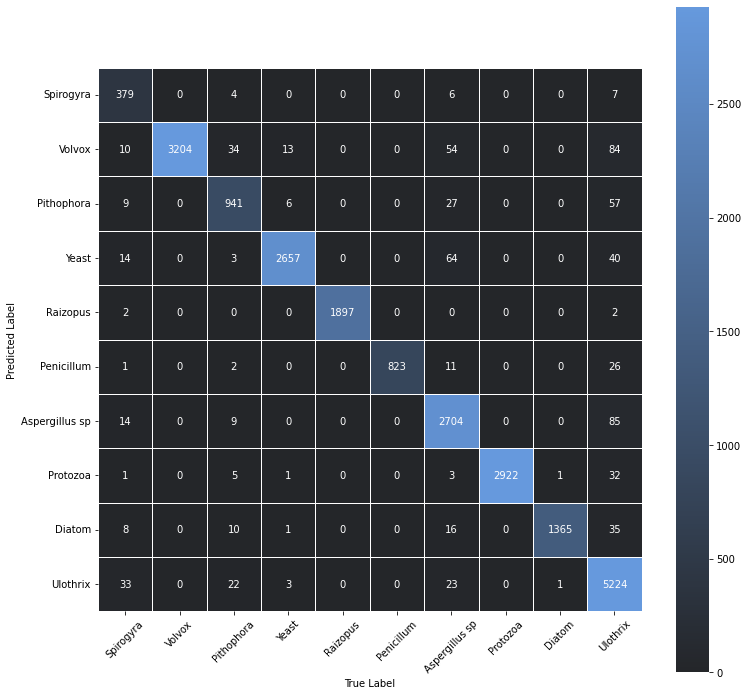

In [519]:
# We're fitting the TRAINING data just to see our training performance
predictions = knn.predict(data.x_train)
truth = data.y_train

# Create a DataTesting() object for evaluation purposes
data_testing = DataTesting(predictions, truth, decoder=int_to_organism)

# Generate a report
results = data_testing.report()
results

# Create our confusion matrix to visualize where we tend to fail
confusion_matrix = data_testing.confusion_matrix()
confusion_matrix

confusion_matrix_plot, _ = data_testing.confusion_matrix_plot(confusion_matrix)

## Hyperparameter Tuning and Cross Validation
It seems that our model fits fairly well, but we can go a bit further! Let's add on some hyper-parameter tuning to our model! Since we do not have very many parameters, we can get away using an exhaustive grid search... we will search each combination of parameters and select the one that performs best on the training data to utilize with the testing data. Since we do not want to create a third set of data, a *validation set*, we can use cross-validation to assess the performance of hyper-parameters on the training data.

In [520]:
# Define our parameter space
parameters = {}
parameters["n_neighbors"] = range(1, 8)
parameters["weights"] = ["uniform", "distance"]
parameters["p"] = [1, 2, float("inf")]


clf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=parameters,
    n_jobs=-1,
    refit=True,
    cv=10,
    verbose=0,
    return_train_score=False
)

clf.fit(data.x_train, data.y_train)

print(clf.best_score_)
print(clf.best_params_)

knn_best = clf.best_estimator_

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 8), 'p': [1, 2, inf],
                         'weights': ['uniform', 'distance']})

0.9808691844992474
{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


### Model Testing
We have finished creating our model. Recall the steps we took in training it:
1. We performed dimensionality reduction to reduce the high-dimensionality space
2. We Assessed the training model with various performance metrics
3. We performed cross validation to pick the best hyper-parameters for the training data
Now that wee have finished training the model, we can use the testing data, `data.x_test` and `data.y_test` to test how the model really performs... Does it overfit? underfit? is it accurate? Where does it fail?

,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix,accuracy,macro avg,weighted avg
precision,0.948276,0.986737,0.940063,0.981681,1.0,0.992278,0.979339,0.983707,0.978308,0.987328,0.983229,0.977772,0.983100
recall,0.785714,1.000000,0.931250,0.991295,1.0,1.000000,0.967347,1.000000,1.000000,0.980306,0.983229,0.965591,0.983229
f1-score,0.859375,0.993324,0.935636,0.986465,1.0,0.996124,0.973306,0.991786,0.989035,0.983805,0.983229,0.970886,0.982991
support,140.000000,1116.000000,320.000000,919.000000,655.0,257.000000,980.000000,966.000000,451.000000,1828.000000,0.983229,7632.000000,7632.000000


,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix
Spirogyra,110.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Volvox,1.0,1116.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0,2.0
Pithophora,7.0,0.0,298.0,0.0,0.0,0.0,2.0,0.0,0.0,10.0
Yeast,3.0,0.0,0.0,911.0,0.0,0.0,8.0,0.0,0.0,6.0
Raizopus,0.0,0.0,0.0,0.0,655.0,0.0,0.0,0.0,0.0,0.0
Penicillum,0.0,0.0,2.0,0.0,0.0,257.0,0.0,0.0,0.0,0.0
Aspergillus sp,10.0,0.0,4.0,0.0,0.0,0.0,948.0,0.0,0.0,6.0
Protozoa,0.0,0.0,4.0,4.0,0.0,0.0,2.0,966.0,0.0,6.0
Diatom,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,451.0,4.0
Ulothrix,7.0,0.0,8.0,0.0,0.0,0.0,8.0,0.0,0.0,1792.0


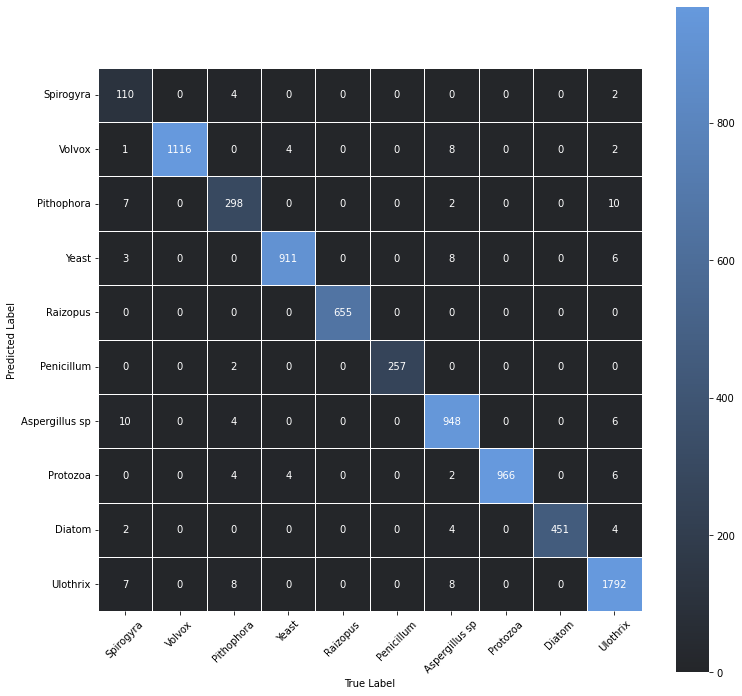

In [521]:
predictions = knn_best.predict(data.x_test)
truth = data.y_test

# Create a DataTesting() object for evaluation purposes
data_testing = DataTesting(predictions, truth, decoder=int_to_organism)

# Generate a report
results = data_testing.report()
results

# Create our confusion matrix to visualize where we tend to fail
confusion_matrix = data_testing.confusion_matrix()
confusion_matrix

confusion_matrix_plot, _ = data_testing.confusion_matrix_plot(confusion_matrix)

### Results
The final model performed very well on the testing data with approximately 98.3% accuracy overall! It appears that `Raizopus` is the easiest organism to classify with 100% accuracy.
- The most extreme performance metric is the `recall` metric for `Spirogyra`: 78.6%. This means that out of the 140 `Spirogyra` total only 110 were correctly identified to be `Spirogyra` by the model. In the confusion matrix, this can be calculated by examining the number of correctly categorized `Spirogyra` in the diagonal of the confusion matrix and dividing it by the sum of the `Spirogyra` column. The precision for `Spirogyra` is calculated similarly, but instead of summing the `Spirogyra` column, we sum the `Spirogyra` row.
- It appears that the most the model most frequently mis-characterizes `Spirogyra` for `Aspergillus sp` (10 wrong predictions) and `Ulothrix` for `Pithophora` (10 wrong predictions).

<figure>
    <img src="Images/Spirogyra.jpeg" alt="drawing" width="225"/><figcaption>Spirogyra</figcaption>
    <img src="Images/Aspergillus sp.png" alt="drawing" width="225"/><figcaption>Aspergillus</figcaption>
    <img src="Images/Ulothrix.jpg" alt="drawing" width="225"/><figcaption>Ulothrix</figcaption>
</figure>

### Conclusion
Overall, it appears that the model works very well. However, this does not mean that no improvements can be made. Notice how feature selection and hyper-parameter optimization were entirely separate. However, there is no reason why feature selection has no effect on the optimal hyper-parameter values. Because of this, it may be possible to reach better model performance by performing feature selection and hyper-parameter optimization at the same time.

Additionally, the high performance is very likely thanks to the genius feature-engineering! If we simply used the straight pixels from the images, we would very likely have a much harder time classifying the microorganisms. Instead, our engineered features explained far greater variance than individuals pixels could.